In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
#from mayavi import mlab
import seaborn as sns
from vtk_rw import read_vtk, write_vtk
from plotting import plot_surf_stat_map, crop_img

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def make_cmap(c):
    #cmap = np.asarray(sns.cubehelix_palette(c-1, start=.5, rot=-.75, reverse=True))
    #cmap = np.asarray(sns.color_palette('cubehelix', c-1))
    cmap = np.asarray(sns.color_palette('Reds', c-1))
    cmap = np.concatenate((np.array([[0.4,0.4,0.4]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [33]:
mesh_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
sulc_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d_sulc.npy'
#mask_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/rh_fullmask.npy'
#data_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/connectivity/rh_smooth_3_embed_10.npy'
data_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/embed0_compartments/rh_smooth_3_embed0_pos_mask_embed.npy'
dict_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/embed0_compartments/rh_smooth_3_embed0_pos_mask_embed_dict.pkl'

In [34]:
data=np.load(data_file)
sulc=np.load(sulc_file)
#mask=np.load(mask_file)
v, f, d = read_vtk(mesh_file)

In [35]:
import pickle
pkl_file = open(dict_file, 'rb')
res = pickle.load(pkl_file)
pkl_file.close()
eigenval=res['lambdas']

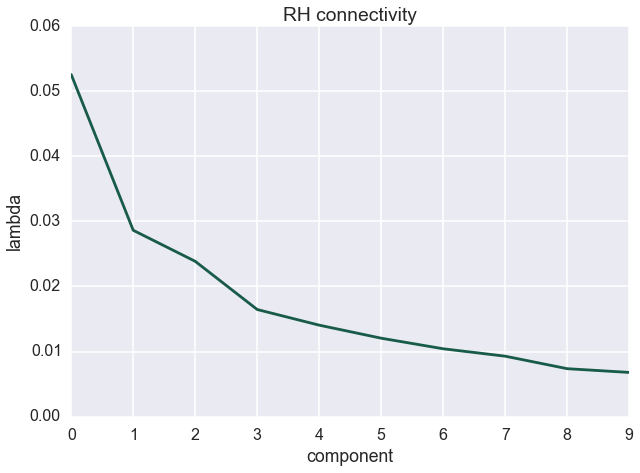

In [36]:
sns.set_context('poster')
sns.set_style('darkgrid')
fig=plt.figure(figsize=(10,7))
plt.plot(eigenval, color=sns.color_palette('cubehelix', 10)[2])
plt.ylabel('lambda')
plt.xlabel('component')
plt.title('RH connectivity')
fig.savefig('/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/figs/connectivity_rh_lambda.png')

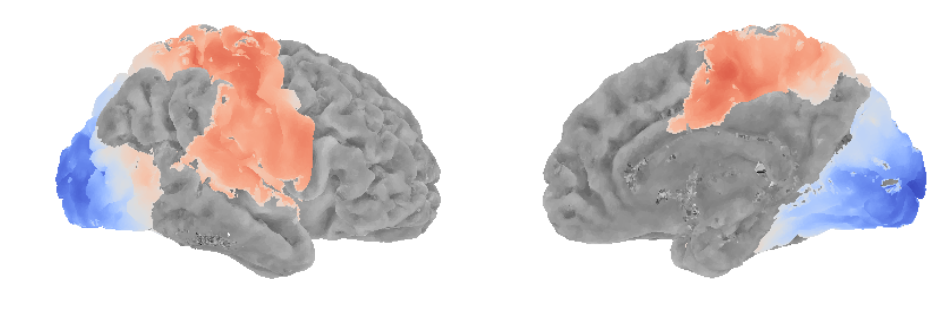

In [37]:
sns.set_style('white')
lat=plot_surf_stat_map(v, f, stat_map=data[:,0], bg_map=sulc, #bg_on_stat=True, darkness=0.5, 
                    elev=180,azim=0, figsize=(11,10) ,threshold=1e-50) #, vmin=1700, vmax=2300)

sns.set_style('white')
med=plot_surf_stat_map(v, f, stat_map=data[:,0], bg_map=sulc, #bg_on_stat=True,darkness=0.5,
        elev=180,azim=180, figsize=(11,10), threshold=1e-50)#, vmin=1700, vmax=2300)
    
        
lat_crop=crop_img(lat)
med_crop=crop_img(med)

fig=plt.figure()
fig.set_size_inches(16, 8)
#ax1 = plt.subplot2grid((4,60), (0,0),  colspan = 26, rowspan =4)
ax1 = fig.add_subplot(121)
plt.imshow(lat_crop)
ax1.set_axis_off()
#ax2 = plt.subplot2grid((4,60), (0,28), colspan = 26, rowspan =4)
ax2 = fig.add_subplot(122)
plt.imshow(med_crop)
ax2.set_axis_off()

#fig.savefig(fig_file % (method, hemi, str(e+1)))
#plt.close(fig)

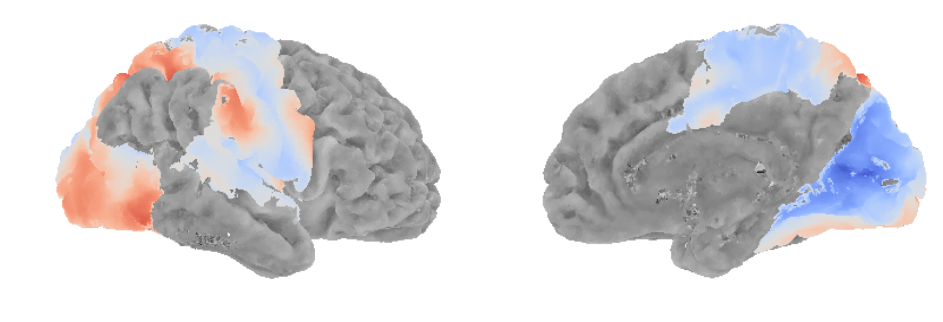

In [38]:
sns.set_style('white')
lat=plot_surf_stat_map(v, f, stat_map=data[:,1], bg_map=sulc, #bg_on_stat=True, darkness=0.5, 
                    elev=180,azim=0, figsize=(11,10) ,threshold=1e-50)#, vmin=1700, vmax=2300)

sns.set_style('white')
med=plot_surf_stat_map(v, f, stat_map=data[:,1], bg_map=sulc, #bg_on_stat=True,darkness=0.5,
        elev=180,azim=180, figsize=(11,10), threshold=1e-50)#, vmin=1700, vmax=2300)
    
        
lat_crop=crop_img(lat)
med_crop=crop_img(med)

fig=plt.figure()
fig.set_size_inches(16, 8)
#ax1 = plt.subplot2grid((4,60), (0,0),  colspan = 26, rowspan =4)
ax1 = fig.add_subplot(121)
plt.imshow(lat_crop)
ax1.set_axis_off()
#ax2 = plt.subplot2grid((4,60), (0,28), colspan = 26, rowspan =4)
ax2 = fig.add_subplot(122)
plt.imshow(med_crop)
ax2.set_axis_off()

#fig.savefig(fig_file % (method, hemi, str(e+1)))
#plt.close(fig)

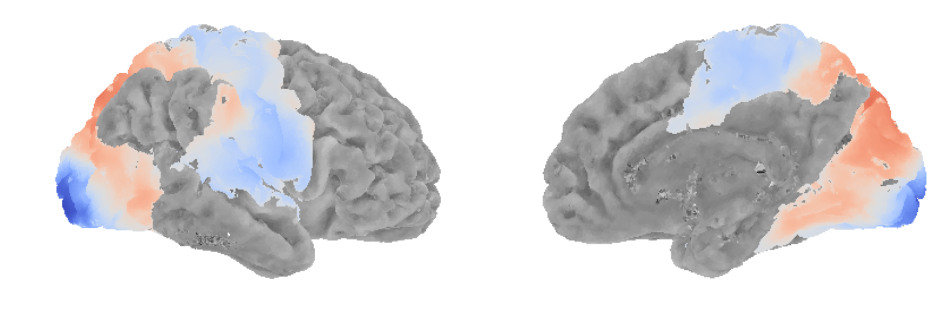

In [39]:
sns.set_style('white')
lat=plot_surf_stat_map(v, f, stat_map=data[:,2], bg_map=sulc, #bg_on_stat=True, darkness=0.5, 
                    elev=180,azim=0, figsize=(11,10) ,threshold=1e-50) #vmin=1700, vmax=2300)

sns.set_style('white')
med=plot_surf_stat_map(v, f, stat_map=data[:,2], bg_map=sulc,# bg_on_stat=True,darkness=0.5,
        elev=180,azim=180, figsize=(11,10),  threshold=1e-50)#', vmin=1700, vmax=2300)
    
        
lat_crop=crop_img(lat)
med_crop=crop_img(med)

fig=plt.figure()
fig.set_size_inches(16, 8)
#ax1 = plt.subplot2grid((4,60), (0,0),  colspan = 26, rowspan =4)
ax1 = fig.add_subplot(121)
plt.imshow(lat_crop)
ax1.set_axis_off()
#ax2 = plt.subplot2grid((4,60), (0,28), colspan = 26, rowspan =4)
ax2 = fig.add_subplot(122)
plt.imshow(med_crop)
ax2.set_axis_off()

#fig.savefig(fig_file % (method, hemi, str(e+1)))
#plt.close(fig)

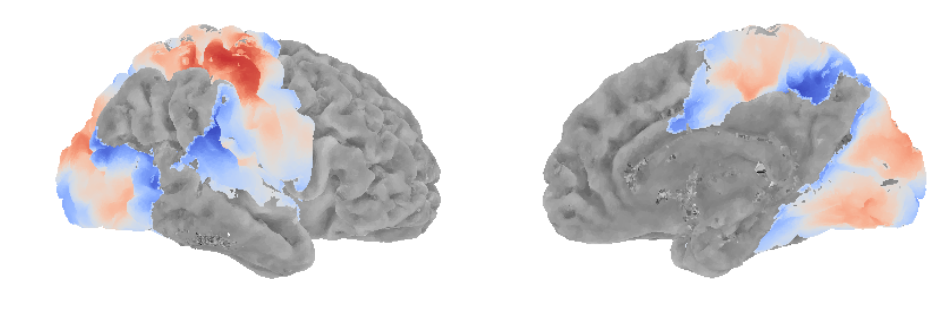

In [40]:
sns.set_style('white')
lat=plot_surf_stat_map(v, f, stat_map=data[:,3], bg_map=sulc, #bg_on_stat=True, darkness=0.5, 
                    elev=180,azim=0, figsize=(11,10) ,threshold=1e-50) #vmin=1700, vmax=2300)

sns.set_style('white')
med=plot_surf_stat_map(v, f, stat_map=data[:,3], bg_map=sulc,# bg_on_stat=True,darkness=0.5,
        elev=180,azim=180, figsize=(11,10),  threshold=1e-50)#', vmin=1700, vmax=2300)
    
        
lat_crop=crop_img(lat)
med_crop=crop_img(med)

fig=plt.figure()
fig.set_size_inches(16, 8)
#ax1 = plt.subplot2grid((4,60), (0,0),  colspan = 26, rowspan =4)
ax1 = fig.add_subplot(121)
plt.imshow(lat_crop)
ax1.set_axis_off()
#ax2 = plt.subplot2grid((4,60), (0,28), colspan = 26, rowspan =4)
ax2 = fig.add_subplot(122)
plt.imshow(med_crop)
ax2.set_axis_off()

#fig.savefig(fig_file % (method, hemi, str(e+1)))
#plt.close(fig)